## Description：
这个笔记本尝试实现一下项亮推荐系统实践里面的ItemCF算法， 采用的数据集是GroupLens提供的MovieLens的其中一个小数据集ml-latest-small。 该数据及包含700个用户对带有6100个标签的10000部电影的100000条评分。 该数据集是一个评分数据集， 用户可以给电影评5个不同等级的分数(1-5)， 而由于我们主要是研究隐反馈数据中的topN推荐问题， 所以忽略了数据集中的评分记录。  **TopN推荐的任务是预测用户会不会对某部电影评分， 而不是预测用户在准备对某部电影评分的前提下给电影评多少分**， 下面我们开始， 从逻辑上看， 其实这个任务主要分为下面的步骤：
1. 导入数据， 读取文件得到"用户-电影"的评分数据， 并且分为训练集和测试集
2. 计算电影之间的相似度
3. 针对目标用户u， 找到其最相似的k个用户， 产生N个推荐
4. 产生推荐之后， 通过准确率、召回率和覆盖率等进行评估。

In [44]:
import os
import time

import json

from operator import itemgetter

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

import random

## Load Json data

In [2]:
def read_josn (path):
    file = open(path, "r", encoding = 'utf-8')
    df = []
    for line in file.readlines():
        dic = json.loads(line)
        df.append(dic)
    return df

In [3]:
# load business data
path = "data/Montréal_Data/Montréal_business.json"
business_list = read_josn(path)
# load reviews data
path = "data/Montréal_Data/Montréal_Review.json"
review_list = read_josn(path)
# load user data
path = "data/Montréal_Data/Montréal_User.json"
user_list = read_josn(path)

## Transform to dataframe

In [4]:
# business list into dataframe
df_business = pd.DataFrame()
business_id = []
name = []
for element in business_list:
    business_id.append(element["business_id"])
    name.append(element["name"])

Business_Num_Id = {}
U = 1
B = 1
Business_Id = []
for index in range(len(business_id)):
    if business_id[index] not in Business_Num_Id.keys():
        Business_Num_Id[business_id[index]] = B
        B = B + 1
    Business_Id.append(Business_Num_Id[business_id[index]])
    

df_business["RawBusinessId"] = business_id
df_business["businessId"] = Business_Id
df_business["title"] = name

df_business.head()

,RawBusinessId,businessId,title
0,i_oghUPqLzzJtxC6Zm-D2A,1,Braseiro
1,735UkyT4px_oeW3iyotGmA,2,Parc-nature de l'Île-de-la-Visitation
2,SWX0K1dpy4fcRq-ktZxmCg,3,Bistro des Moulins
3,spi9UEWyNrq2O4y5DD84LA,4,Restaurant Nhu Y
4,cBQDYO0dIpG6--I3DMiWoQ,5,Secrets de Femme


In [5]:
# User list into dataframe
df_user = pd.DataFrame()
user_id = []
name = []
for element in user_list:
    user_id.append(element["user_id"])
    name.append(element["name"])

User_Num_Id = {}
U = 1
User_Id = []
for index in range(len(user_id)):
    if user_id[index] not in User_Num_Id.keys():
        User_Num_Id[user_id[index]] = U
        U = U + 1
    User_Id.append(User_Num_Id[user_id[index]])
    
df_user["RawUserId"] = user_id
df_user["UserId"] = User_Id
df_user["name"] = name

df_user.head()

,RawUserId,UserId,name
0,jx-BchSqX2PlnMflR62Urw,1,Jack
1,4TCOItk-gIJROyNA5ftZ-Q,2,Alma
2,i7dva-DqwjyAtLVc2idhNA,3,Pradeep
3,U4INQZOPSUaj8hMjLlZ3KA,4,Michael
4,B4GZ3kX1TpxJUCkpPqYqng,5,Vivian


In [6]:
# review list into dataframe
df_ratings = pd.DataFrame()
#review_id = []
user_id = []
business_id = []
ratings = []
for element in review_list:
    uid = User_Num_Id[element["user_id"]]
    bid = Business_Num_Id[element["business_id"]]
    
    user_id.append(uid)
    business_id.append(bid)
    ratings.append(element["stars"])

#df_ratings["review_id"] = review_id
df_ratings["userId"] = user_id
df_ratings["businessId"] = business_id
df_ratings["rating"] = ratings

df_ratings.head()

,userId,businessId,rating
0,579,604,3.0
1,5400,91,4.0
2,1273,442,3.0
3,1202,478,5.0
4,3358,202,1.0


## Filter data
### For business

In [7]:
# get rating frequency
df_business_cnt = pd.DataFrame(df_ratings.groupby('businessId').size(), columns=['count'])
df_business_cnt.head()

,count
businessId,
1,22
2,10
3,3
4,11
5,3


In [8]:
# top quantiles of rating counts
df_business_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    2348.0
0.95      84.0
0.90      51.0
0.85      35.0
0.80      27.0
0.75      21.0
0.70      16.6
0.65      14.0
Name: count, dtype: float64

In [10]:
# filter data - movies count less than 20
popularity_thres = 10
popular_business = list(set(df_business_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_business = df_ratings[df_ratings.businessId.isin(popular_business)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular business: ', df_ratings_drop_business.shape)

shape of original ratings data:  (151238, 3)
shape of ratings data after dropping unpopular business:  (133714, 3)


### For users

In [11]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_business.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,2
2,11
3,49
4,20
5,4


In [12]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    617.0
0.95      9.0
0.90      5.0
0.85      4.0
0.80      3.0
0.75      3.0
0.70      2.0
0.65      2.0
0.60      2.0
0.55      1.0
Name: count, dtype: float64

In [13]:
# filter data
ratings_thres = 2
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_business[df_ratings_drop_business.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular business and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (151238, 3)
shape of ratings data after dropping both unpopular business and inactive users:  (108683, 3)


In [14]:
df_ratings_drop_users.index = list(range(0, df_ratings_drop_users.shape[0]))
df_ratings_drop_users

,userId,businessId,rating
0,579,604,3.0
1,5400,91,4.0
2,1273,442,3.0
3,1202,478,5.0
4,3358,202,1.0
...,...,...,...
108678,5720,5837,1.0
108679,27409,5821,5.0
108680,39378,6252,5.0
108681,20833,5912,5.0


In [87]:
print(len(np.unique(df_ratings_drop_users['userId'])))
print(len(np.unique(df_ratings_drop_users['businessId'])))

18614
2891


## Transform dataframe to dictionary

In [110]:
# Define 2 dictionaries, one is for training set, the other is for test set.
trainSet, testSet = {}, {}
trainSet_len, testSet_len = 0, 0
pivot = 0.75    # Propotion of training set.

# Traverse every row of data， store in the format as {businessId: {userId: rating}}.
for ele in df_ratings_drop_users.itertuples():
    user, business, rating = getattr(ele, 'userId'), getattr(ele, 'businessId'), getattr(ele, 'rating')
    if random.random() < pivot:
        trainSet.setdefault(business, {})
        trainSet[business][user] = rating
        trainSet_len += 1
    else:
        testSet.setdefault(business, {})
        testSet[business][user] = rating 
        testSet_len += 1

print('Split new trainingSet and new testSet success!')
print('TrainSet = %s' % trainSet_len)
print('TestSet = %s' % testSet_len)

Split new trainingSet and new testSet success!
TrainSet = 81502
TestSet = 27181


## Calculate the similarity beween each 2 business 


In [17]:
# Calculate the popularity for each business, which is how many times each business is rated by users.
train_business_popular = {}
for m in trainSet.keys():
    if m not in train_business_popular.keys():
        train_business_popular[m] = len(trainSet[m])

In [106]:
# Create business similarity matrix.
def get_business_sim_matrix(trainSet):
    print('Build user co-rated movies matrix ...')
    business_sim_matrix = {}
    for b1 in trainSet.keys():     
        for b2 in trainSet.keys():
            if b1 == b2:
                continue
            business_sim_matrix.setdefault(b1, {})      
            business_sim_matrix[b1].setdefault(b2, 0)
            u1 = list(trainSet[b1].keys())
            u2 = list(trainSet[b2].keys())
            u_intersect = list(set(u1) & set(u2))
            numerator = 0
            for u in u_intersect:
                numerator += trainSet[b1][u] * trainSet[b2][u]
            denominator = pow(sum(list(map(lambda x: x**2,  list(trainSet[b1].values())))), 0.5) * pow(sum(list(map(lambda x: x**2,  list(trainSet[b2].values())))), 0.5)
            business_sim_matrix[b1][b2] = numerator / denominator

    print('Build user co-rated movies matrix success!')
    return business_sim_matrix

In [107]:
# 这里先把产生推荐的那个封装成函数才能测试所有的测试样本
def recommend(aim_user, trainSet, k=20, n=5):
    rank ={}
    rated_business = {}   # 找出目标用户

    for b in trainSet.keys():
        if aim_user in trainSet[b].keys():
            rated_business[b] = trainSet[b][aim_user]

    for business, rating in rated_business.items():
        #遍历与物品item最相似的前k个产品，获得这些物品及相似分数
        for related_business, w in sorted(get_business_sim_matrix(trainSet)[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # 若该物品用户看过， 跳过
            if related_business in rated_business:
                continue

            # 计算用户user对related_movie的偏好值， 初始化该值为0
            rank.setdefault(related_business, 0)
            #通过与其相似物品对物品related_movie的偏好值相乘并相加。
            #排名的依据—— > 推荐电影与该已看电影的相似度(累计) * 用户对已看电影的评分
            rank[related_business] += w * float(rating)

    # 产生最后的推荐列表
    return sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]  # itemgetter(1) 是简洁写法

In [124]:
# Recommended 10 merchants per user for 3 users
trainSet_temp = trainSet
# Calculate the popularity for each business, which is how many times each business is rated by users.
train_business_popular_temp = train_business_popular

# fig, ax = plt.subplots(1, 5)
plt.figure(figsize=(16, 8))
for i in range(5):

    rec_list = []
    train_user = []

    for b in trainSet_temp.values():
        for u in b.keys():
            if u not in train_user:
                train_user.append(u)

    train_user = random.sample(train_user, 3)
    
    for u_id in train_user:   
        rec_list.append(recommend(u_id, trainSet_temp, k=20, n=20))

    # Count the number of times that each business that appears in the user's recommendation list is recommended.
    rec_freq = {}
    for rec in rec_list:
        for b in rec:
            if b[0] not in rec_freq.keys():
                rec_freq[b[0]] = 1
            else:
                rec_freq[b[0]] = rec_freq[b[0]] + 1

    # Obtain the popularity of recommended business
    rec_business_popular = {}

    for b in rec_freq.keys():
        rec_business_popular[b] = train_business_popular_temp[b]

    # Graph the popularity of the business aginst the number of referrals.
    x_popularity = list(rec_business_popular.values())
    y_recommendation_frequency = list(rec_freq.values())
    
    plt.subplot(2, 3, i + 1) #做一个3*3的图 range（9）从0开始，因需要从1开始，所以i+1
    plt.scatter(x_popularity, y_recommendation_frequency,s=30,marker='o')
    plt.xlabel('Movie Popularity',fontsize=12)  
    plt.ylabel('Recommendation frequency',fontsize=12)
    print("Graph " + str(i+1) + " has been generated.")

    # Update the user rating matrix.
    for j in range(len(rec_list)):
        for b in rec_list[j]:
            b_id = b[0]
            r = b[1]
            trainSet_temp[b_id][j] = r
    
    # Update the business popularity
    train_business_popular_temp = {}
    for b in trainSet_temp.keys():
        if b not in train_business_popular_temp.keys():
            train_business_popular_temp[b] = len(trainSet_temp[b])

plt.show()
plt.suptitle("Item CF")

Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies matrix ...
Build user co-rated movies matrix success!
Build user co-rated movies m

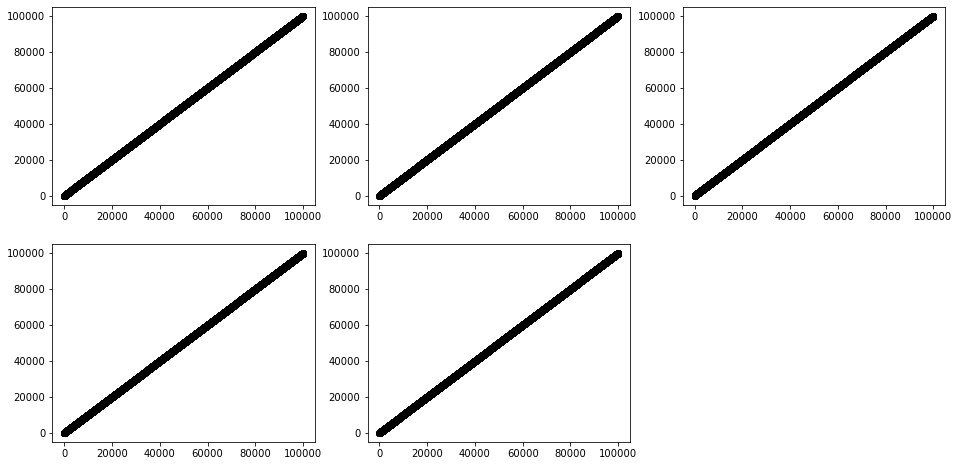

In [123]:
plt.figure(figsize=(16, 8))
x = range(100000) #画散点图x与y要size相同
y = range(100000)
for i in range(5): 
    plt.subplot(2, 3, i + 1) #做一个3*3的图 range（9）从0开始，因需要从1开始，所以i+1
    plt.scatter(x,y,color = 'black')#关闭坐标 让图更美观
plt.show()

## Reduce popularity bias:

In [39]:
# Get the average rating of each user
user_average_rating = df_ratings_drop_users.groupby('userId').mean()['rating']

In [43]:
alpha = np.arange(0.2, 0.7, 0.1)
alpha

array([0.2, 0.3, 0.4, 0.5, 0.6])

In [67]:
# Calculate the norm popularity for each business, which is how many times each business is rated by users.
train_norm_business_popular = {}


for b in trainSet.keys():
    if b not in train_norm_business_popular.keys():
        train_norm_business_popular[b] = len(trainSet[b])
        
max_pop = max(train_norm_business_popular.values())
min_pop = min(train_norm_business_popular.values())

for b, pop in train_norm_business_popular.items():
    train_norm_business_popular[b] = pop / (max_pop - min_pop)
    if train_norm_business_popular[b] > 1:
        train_norm_business_popular[b] = 1

In [ ]:
# Create business similarity matrix.
print('Build user co-rated movies matrix ...')
business_sim_matrix = {}
for b1 in trainSet.keys():     
    for b2 in trainSet.keys():
        if b1 == b2:
            continue
        business_sim_matrix.setdefault(b1, {})      
        business_sim_matrix[b1].setdefault(b2, 0)
        u1 = list(trainSet[b1].keys())
        u2 = list(trainSet[b2].keys())
        u_intersect = list(set(u1) & set(u2))
        numerator = 0
        for u in u_intersect:
            numerator += trainSet[b1][u] * trainSet[b2][u]
        denominator = pow(sum(list(map(lambda x: x**2,  list(trainSet[b1].values())))), 0.5) * pow(sum(list(map(lambda x: x**2,  list(trainSet[b2].values())))), 0.5)
        business_sim_matrix[b1][b2] = numerator / denominator

print('Build user co-rated movies matrix success!')